# Demonstrator for computationally accelerated experimental characterization of electrical resistance

This notebook showcases the use of pyiron to computationally accelerate an experimental characterization of the resistance of a composition spread materials library containing elements Ir, Pd, Pt, Rh, Ru. Instead of measuring *all* positions, the measurement is based on an initial choice of 5 points that are used to fit a Gaussian Process. Subsequent measurements are then given by locations of maximum covariance which is data that maximally improves the model prediction.

pyiron is used to store and steer the data through a `ResistanceGP` job which encapsulates the Gaussian Process Regression using `GPy`. Access to experimental data is provided via a dummy interface to an experimental device inside this job using our library `autonoexp`.

Authors: Markus Stricker, Lars Banko, Nik Sarazin, Niklas Siemer, Jörg Neugebauer, Alfred Ludwig

In [1]:
%matplotlib notebook

In [2]:
from pyiron_experimental import resistance_mdi
from pyiron_base import Project
import pandas as pd
import matplotlib.pyplot as plt

/home/markus/miniconda3/envs/acc_char/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
project = Project("./exp_comp_acc/")
project.remove_jobs_silently()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 69.54it/s]


In [4]:
job_measure = project.create_job(resistance_mdi.ResistanceGP, "resistance_gp")

Default input parameters is provided by the class:

In [5]:
print("Used parameters:")
for key in job_measure.input:
    print(key, job_measure.input[key])



Used parameters:
exp_user None
measurement_device <class 'type'>
sample_id 12345
measure_indices [5, 157, 338, 177, 188]
sample_file None
max_gp_iterations 10
element_column_ids None


We overwrite the defaults with our data and metadata.

In [6]:
data_file = "Ir-Pd-Pt-Rh-Ru_dataset.csv"
job_measure.input.sample_file = data_file
job_measure.input.element_column_ids = [3,-1]
job_measure.input['max_gp_iterations'] = 40

We now have access to the dummy device and the process can run.

In [7]:
job_measure.run()

The job resistance_gp was saved and received the ID: 979


AttributeError: 'str' object has no attribute 'columns'

In [8]:
df = job_measure.device.raw_df
elements = df.columns[3:-1]
properties = df.columns[3:]

<IPython.core.display.Javascript object>


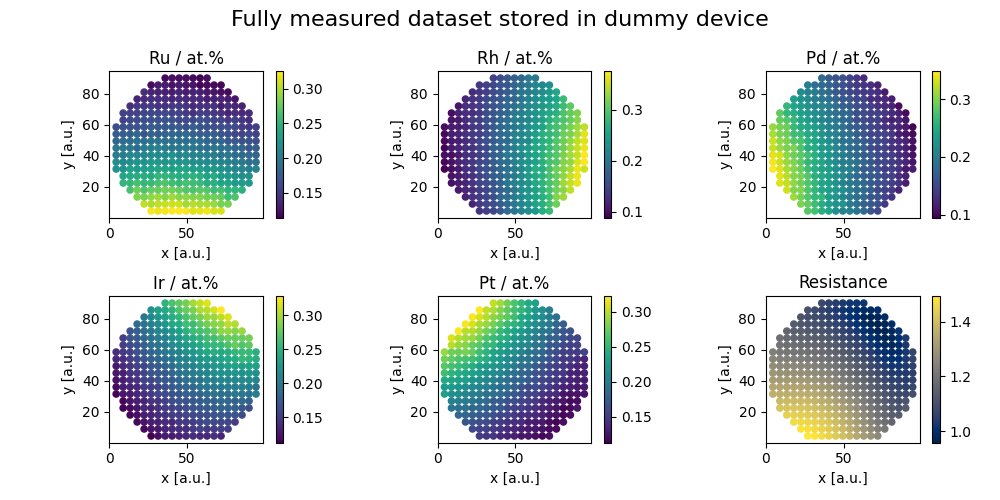

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5))
fig.suptitle('Fully measured dataset stored in dummy device', fontsize=16)
dot_size = 20
scale = 1000
axs = axs.ravel()
for i, p in enumerate(properties):
    #print("i,p = {},{}".format(i,p))
    #print(df[p])
    if p == "Resistance":
        sc = axs[i].scatter(df.x/scale, df.y/scale, c=df.Resistance, s=dot_size,
                            cmap='cividis')
        plt.colorbar(sc, ax=axs[i])
        axs[i].set_title(p)
        axs[i].set_aspect('equal')
    else:
        sc = axs[i].scatter(df.x/scale, df.y/scale, c=df[p], s=dot_size)
        plt.colorbar(sc, ax=axs[i])
        axs[i].set_title(p + " / at.%")
    axs[i].set_aspect('equal')
    axs[i].set_ylabel("y [a.u.]")
    axs[i].set_xlabel("x [a.u.]")

plt.tight_layout()

<IPython.core.display.Javascript object>


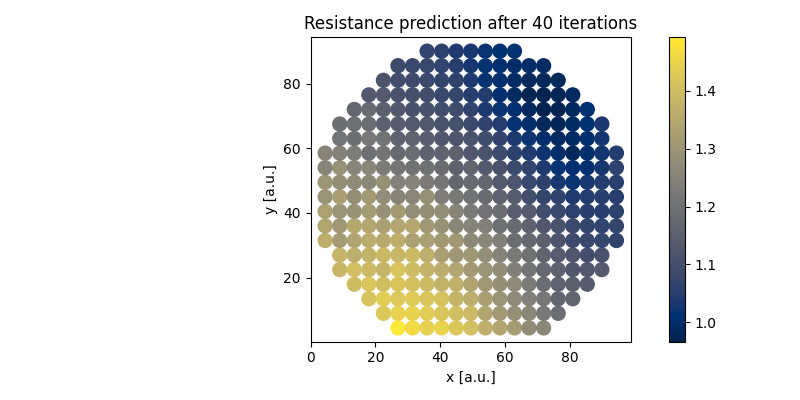

In [10]:
fig_pred, ax_pred = plt.subplots(1,1, figsize=(8,4))

sc = ax_pred.scatter(df.x/scale, df.y/scale, c=job_measure.output['resistance_prediction'],
                     s=dot_size*5, cmap='cividis')
plt.colorbar(sc, ax=ax_pred)
ax_pred.set_ylabel("y [a.u.]")
ax_pred.set_xlabel("x [a.u.]")
ax_pred.set_title("Resistance prediction after {} iterations".format(job_measure.input['max_gp_iterations']))
ax_pred.set_aspect('equal')
plt.tight_layout()